In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import time

In [3]:
def create_generator_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(4*4*1024, use_bias=False, input_shape=(128,)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.ReLU())

    model.add(tf.keras.layers.Reshape((4,4,1024)))
    
    model.add(tf.keras.layers.Conv2DTranspose(516, (3, 3), strides=(2, 2), padding='same', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.ReLU())
    
    model.add(tf.keras.layers.Conv2DTranspose(256, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.ReLU())
    
    model.add(tf.keras.layers.Conv2DTranspose(128, (7, 7), strides=(2, 2), padding='same', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.ReLU())

    model.add(tf.keras.layers.Conv2DTranspose(64, (7, 7), strides=(2, 2), padding='same', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.ReLU())

    model.add(tf.keras.layers.Conv2DTranspose(3, (7, 7), strides=(1, 1), padding='same', use_bias=False, activation='tanh'))

    return model

In [36]:
def create_discriminator_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(32, (7, 7), strides=(2, 2), padding='same',input_shape=[64,64,3],activation = 'relu'))

    model.add(tf.keras.layers.Conv2D(64, (7, 7), strides=(2, 2), padding='same',activation = 'relu'))
    model.add(tf.keras.layers.Conv2D(128, (7, 7), strides=(2, 2), padding='same',activation = 'relu'))
    model.add(tf.keras.layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same',activation = 'relu'))

    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(128))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(32))
    model.add(tf.keras.layers.Dense(1,activation = 'sigmoid'))

    return model

In [67]:
dtrfol = "./AnimeData"
BATCH = 32

In [69]:
def process(img):
    return (img-127.5)/127.5

In [70]:
TrainDataGen = tf.keras.preprocessing.image_dataset_from_directory(dtrfol,batch_size=BATCH,image_size=(64,64),label_mode = None)
TrainDataGen.batch(batch_size=BATCH)

Found 21551 files belonging to 1 classes.


<BatchDataset shapes: (None, None, 64, 64, 3), types: tf.float32>

In [71]:
TrainDataGen = TrainDataGen.map(process)

In [72]:
generator = create_generator_model()
discriminator = create_discriminator_model()

In [73]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits = False)

def discriminator_loss(fake_outputs,real_outputs):
    return cross_entropy(tf.ones_like(real_outputs),real_outputs) + cross_entropy(tf.zeros_like(fake_outputs),fake_outputs)

def generator_loss(fake_outputs):
    return cross_entropy(tf.ones_like(fake_outputs),fake_outputs)

In [74]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [75]:
EPOCHS = 100
noise_dim = 128
num_examples_to_generate = 10

seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [80]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(fake_output, real_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [84]:
def generate_images(gen, epoch):
    generated_image = gen(seed, training=False)

    fig = plt.figure(figsize=(4, 4))

    for i in range(generated_image.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(generated_image[i, :, :, 0] * 127.5 + 127.5)
        plt.axis('off')

    plt.savefig('./AnimeDCGAN/image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

In [85]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        for image_batch in dataset:
            train_step(image_batch)

        generate_images(generator,epoch + 1)

        if (epoch + 1) % 20 == 0:
            checkpoint.save(file_prefix = cp_prefix)

        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

    generate_and_save_images(generator,epochs)

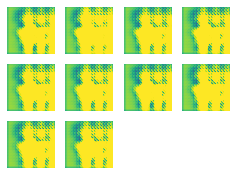

Time for epoch 1 is 389.9567437171936 sec


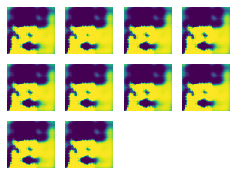

Time for epoch 2 is 336.26977944374084 sec


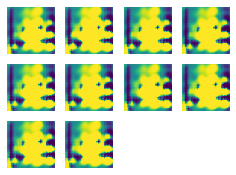

Time for epoch 3 is 375.8257966041565 sec


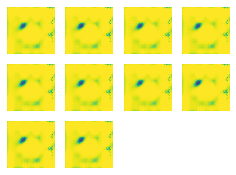

Time for epoch 4 is 393.39384055137634 sec


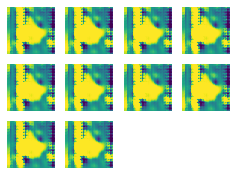

Time for epoch 5 is 393.66865587234497 sec


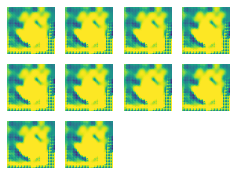

Time for epoch 6 is 393.93223428726196 sec


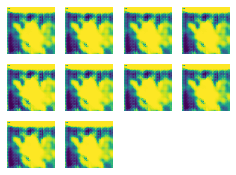

Time for epoch 7 is 390.9397418498993 sec


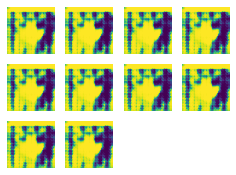

Time for epoch 8 is 387.095662355423 sec


In [ ]:
train(TrainDataGen, EPOCHS)